### imports

In [ ]:
import numpy as np 
import pandas as pd 

### simulator

A desired SDE can be simulated through the following equation: 

$dX_t = f(X_t)dt + g(X_t)dW_t$, where these inputs are the following 

- $f(X_t)$ is the custom drift or deterministic baseline function
- $g(X_t)$ is the diffusion (stochastic part) that scales randomness factor
- $dW_t$ the wiener process (brownian motion)

We will use these as inputs to our simulator, and different inputs will create different SDE

In [2]:
def eu_simulator(f_t, g_t, W_t, x0, T, dt):
    """
    Simulate an SDE using the Euler-Maruyama method.
    
    Parameters:
    f_t: function - the drift function f(X_t)
    g_t: function - the diffusion function g(X_t)
    W_t: array-like - the Wiener process increments
    x0: float - initial condition
    T: float - total time to simulate
    dt: float - time step size
    
    Returns:
    X: array - simulated values of X_t at each time step
    """
    N = int(T / dt)  # number of time steps
    X = np.zeros(N + 1)
    X[0] = x0
    
    for i in range(1, N + 1):
        t = i * dt
        dW = W_t[i-1]  # Wiener increment for this time step
        X[i] = X[i-1] + f_t(X[i-1]) * dt + g_t(X[i-1]) * dW
        
    return X 


### simulating OU Process

In [5]:
def make_ou_drift(mu, theta):
    """Return f_t(x) = theta * (mu - x) for an OU process."""
    return lambda x: theta * (mu - x)  

def make_ou_diffusion(sigma):
    """Return g_t(x) = sigma (state-independent diffusion for OU)."""
    return lambda x: sigma 

def wiener_increments(N, dt, rng=None):
    """Generate N i.i.d. Wiener increments ~ N(0, dt)."""
    rng = np.random.default_rng(rng)  
    return rng.normal(loc=0.0, scale=np.sqrt(dt), size=N)  

In [6]:
def generate_ou_series(mu, theta, sigma, x0, T, dt, seed=None, method="euler"):
    """
    Generate a single OU path X_t using eu simulator
    """
    N = int(T / dt)                               
    W = wiener_increments(N, dt, rng=seed)      
    f_t = make_ou_drift(mu, theta)               
    g_t = make_ou_diffusion(sigma)               
    X = eu_simulator(f_t, g_t, W, x0, T, dt)     
    return X                                     

In [7]:
def generate_ou_paths(mu, theta, sigma, x0, T, dt, n_series, seed=None):
    """
    Generate multiple independent OU paths (shape: n_series x (N+1)).
    """
    N = int(T / dt)                                   
    rng = np.random.default_rng(seed)                 
    X_panel = np.empty((n_series, N + 1), float)      
    f_t = make_ou_drift(mu, theta)                    
    g_t = make_ou_diffusion(sigma)                    
    for i in range(n_series):                         
        W = rng.normal(0.0, np.sqrt(dt), size=N)      
        xi0 = x0                                      
        X_panel[i] = eu_simulator(f_t, g_t, W, xi0, T, dt)  
    return X_panel                                    # return all paths
    

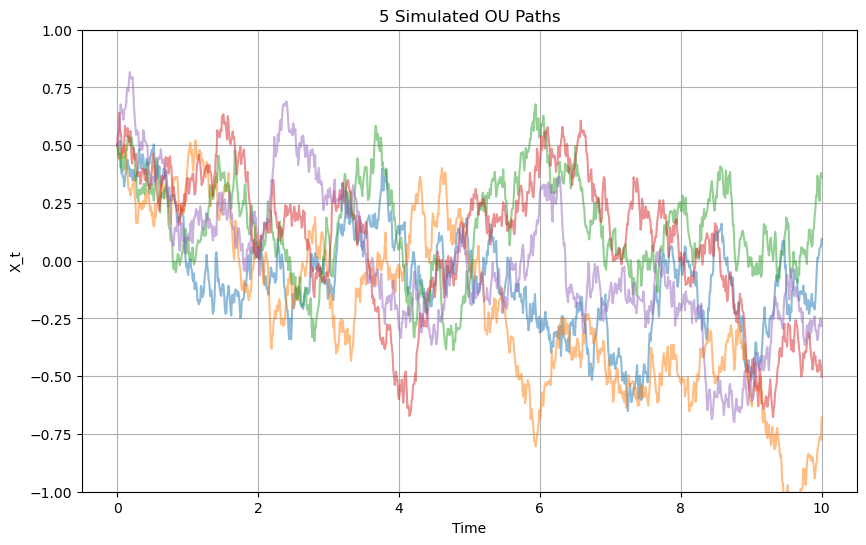

In [15]:
import matplotlib.pyplot as plt 
import seaborn as sns 
### plot all the realizations of a generated dataset 
mu, theta, sigma = 0.0, 1.0, 0.4
x0, T, dt = 0.5, 10.0, 0.01
n_series = 5

X_panel = generate_ou_paths(mu, theta, sigma, x0, T, dt, n_series, seed=42)

plt.figure(figsize=(10,6)) 
for i in range(n_series):
    plt.plot(np.arange(0, T + dt, dt), X_panel[i], alpha=0.5)
plt.title('5 Simulated OU Paths')
plt.ylim(-1,1)
plt.xlabel('Time')
plt.ylabel('X_t')
plt.grid()
plt.show()

In [ ]:
#save ou process into csv with 100 realizations
mu, theta, sigma = 0.0, 1.0, 0.4
x0, T, dt = 0.5, 10.0, 0.01
n_series = 100

X_panel = generate_ou_paths(mu, theta, sigma, x0, T, dt, n_series, seed=42)


In [14]:
import pandas as pd 
df = pd.DataFrame(X_panel) 
df.head()

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,1000
0,0.5,0.507189,0.460517,0.485930,0.518694,0.435465,0.379023,0.380347,0.363894,0.359583,...,-0.173720,-0.112811,-0.039909,0.013083,0.008563,0.022586,0.053033,0.057350,0.062007,0.094337
1,0.5,0.492629,0.458531,0.437367,0.458349,0.453886,0.462955,0.485129,0.465284,0.490881,...,-0.917200,-0.886215,-0.868087,-0.820799,-0.809076,-0.785305,-0.765299,-0.761307,-0.774927,-0.678612
2,0.5,0.476922,0.445518,0.458423,0.463913,0.403082,0.443958,0.435751,0.386956,0.430638,...,0.217256,0.280180,0.275016,0.367875,0.344780,0.310674,0.259165,0.349815,0.379094,0.361939
3,0.5,0.544961,0.567019,0.639994,0.571681,0.555349,0.531295,0.447035,0.484978,0.469312,...,-0.413155,-0.450388,-0.458081,-0.481114,-0.452227,-0.474856,-0.429641,-0.435173,-0.456806,-0.502370
4,0.5,0.505128,0.535886,0.541460,0.625598,0.676534,0.657467,0.638172,0.650578,0.610551,...,-0.300344,-0.299974,-0.319529,-0.343426,-0.322842,-0.276514,-0.287479,-0.253377,-0.248854,-0.282074


In [16]:
df.to_csv('../data/ou_process_simulation.csv', index=False)